In [723]:
import functions_exp_kernel as fn
import importlib
importlib.reload(fn)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import differential_evolution
import scipy.linalg
from sklearn.covariance import MinCovDet
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score
import time
import random
np.random.seed(0)
random.seed(0)


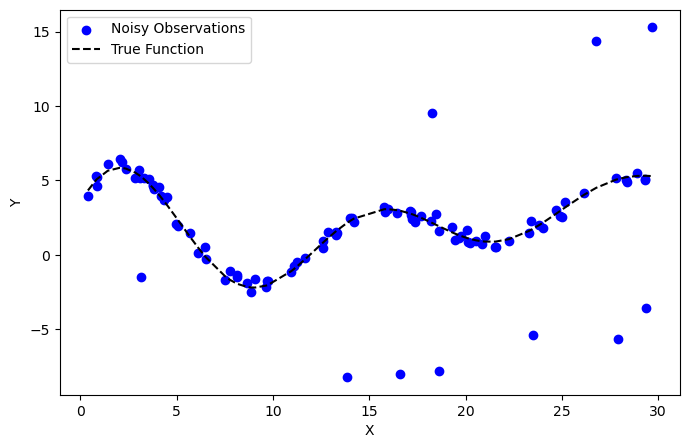

In [769]:
def ground_truth_function(x):
    return np.sin(0.5 * x) * (10 * np.log(x + 2) / x) + (x ** 2) / 200

np.random.seed(0)  
n = 100
X = np.random.uniform(0.25, 30, n)  
X = np.sort(X)
noise_variance = 0.1
noise = np.random.normal(0, np.sqrt(noise_variance), X.shape)
Y = ground_truth_function(X) + noise

#---------------------------5% Contamination -------------------------------
# Outlier contamination
outlier_ratio = 0.05
num_outliers = int(outlier_ratio * len(Y))

# Randomly select indices for outliers
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)

# Compute outlier magnitude (random value in [3σ, 5σ])
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers)

# Randomly add or subtract outlier magnitude
outlier_sign = np.random.choice([-1, 1], num_outliers)

Y_5 = Y.copy() 
Y_5[outlier_indices] += outlier_sign * outlier_magnitude  # Apply perturbation

#----------------------------------------------------------------------------


#---------------------------10% Contamination -------------------------------
# Outlier contamination
outlier_ratio = 0.1
num_outliers = int(outlier_ratio * len(Y))

# Randomly select indices for outliers
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)

# Compute outlier magnitude (random value in [3σ, 5σ])
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers)

# Randomly add or subtract outlier magnitude
outlier_sign = np.random.choice([-1, 1], num_outliers)

Y_10 = Y.copy() 
Y_10[outlier_indices] += outlier_sign * outlier_magnitude  # Apply perturbation

#----------------------------------------------------------------------------

#---------------------------15% Contamination -------------------------------
# Outlier contamination
outlier_ratio = 0.15
num_outliers = int(outlier_ratio * len(Y))

# Randomly select indices for outliers
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)

# Compute outlier magnitude (random value in [3σ, 5σ])
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers)

# Randomly add or subtract outlier magnitude
outlier_sign = np.random.choice([-1, 1], num_outliers)

Y_15 = Y.copy() 
Y_15[outlier_indices] += outlier_sign * outlier_magnitude  # Apply perturbation

#----------------------------------------------------------------------------


#---------------------------20% Contamination -------------------------------
# Outlier contamination
outlier_ratio = 0.2
num_outliers = int(outlier_ratio * len(Y))

# Randomly select indices for outliers
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)

# Compute outlier magnitude (random value in [3σ, 5σ])
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers)

# Randomly add or subtract outlier magnitude
outlier_sign = np.random.choice([-1, 1], num_outliers)

Y_20 = Y.copy() 
Y_20[outlier_indices] += outlier_sign * outlier_magnitude  # Apply perturbation

#----------------------------------------------------------------------------




X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

plt.figure(figsize=(8, 5))
plt.scatter(X, Y_10, color='blue', label="Noisy Observations")
plt.plot(X, ground_truth_function(X), color='black', linestyle="dashed", label="True Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
#plt.savefig("plot_synthetic_data.pdf", format="pdf", bbox_inches="tight")

In [771]:
theta_SGP = 0.1146
sigma_SGP = np.sqrt(0.0842)
theta_RWGP = 0.1084
sigma_RWGP = np.sqrt(0.0343)
theta_DWGP = 0.1099
sigma_DWGP = np.sqrt(0.0139)
k = 6

In [827]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_15, test_size = 0.4, random_state = 1)

# Ensure X_train is 2D
X_train = X_train.reshape(-1, 1)

y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1) 

sorted_indices = np.argsort(X_train.flatten())  # Get sorting indices
X_train = X_train[sorted_indices]  # Apply sorting to X_test
y_train = y_train[sorted_indices]  # Apply sorting to y_test

# Ensure that X_test and y_test are sorted together
sorted_indices = np.argsort(X_test.flatten())  # Get sorting indices
X_test = X_test[sorted_indices]  # Apply sorting to X_test
y_test = y_test[sorted_indices]  # Apply sorting to y_test


In [829]:
nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

depth = np.zeros(len(X_train))
for i in range(len(X_train)):
    depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
weight_depth_opt = fn.weight(1-depth, gamma, lamda)
mu_s_DWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)

In [831]:
w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)

In [833]:
mu_s_SGP, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)

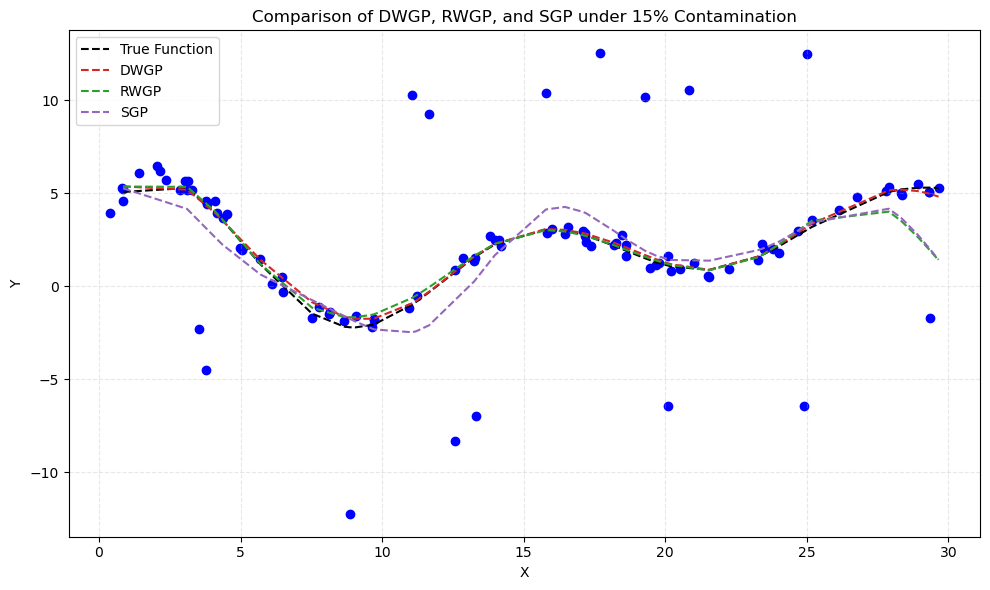

In [835]:
colors = {
    "true_function": "#000000",  # Black
    "observations": "#1f77b4",  # Blue
    "DWGP": "#d62728",  # Red
    "RWGP": "#2ca02c",  # Green
    "SGP": "#9467bd", # Purple
}


plt.figure(figsize=(10, 6))

# تابع واقعی
plt.plot(X_test, ground_truth_function(X_test), color=colors["true_function"], linestyle="dashed", label="True Function")
plt.scatter(X_test, y_test, color='blue')
plt.scatter(X_train, y_train, color='blue')
# پیش‌بینی مدل‌ها
plt.plot(X_test, mu_s_DWGP, color=colors["DWGP"], label="DWGP", linestyle="dashed")
plt.plot(X_test, mu_s_RWGP, color=colors["RWGP"], label="RWGP", linestyle="dashed")
plt.plot(X_test, mu_s_SGP, color=colors["SGP"], label="SGP", linestyle="dashed")


plt.xlabel("X")
plt.ylabel("Y")
plt.title("Comparison of DWGP, RWGP, and SGP under 15% Contamination")

plt.legend(loc="upper left", fontsize=10)
#plt.ylim([-5, 15])
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("plot15.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()

In [817]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_5, test_size = 0.4, random_state = 111)

# Ensure X_train is 2D
X_train = X_train.reshape(-1, 1)

y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1) 

sorted_indices = np.argsort(X_train.flatten())  # Get sorting indices
X_train = X_train[sorted_indices]  # Apply sorting to X_test
y_train = y_train[sorted_indices]  # Apply sorting to y_test

# Ensure that X_test and y_test are sorted together
sorted_indices = np.argsort(X_test.flatten())  # Get sorting indices
X_test = X_test[sorted_indices]  # Apply sorting to X_test
y_test = y_test[sorted_indices]  # Apply sorting to y_test


In [819]:
nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

depth = np.zeros(len(X_train))
for i in range(len(X_train)):
    depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
weight_depth_opt = fn.weight(1-depth, gamma, lamda)
mu_s_DWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)

In [821]:
w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)

In [823]:
mu_s_SGP, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)

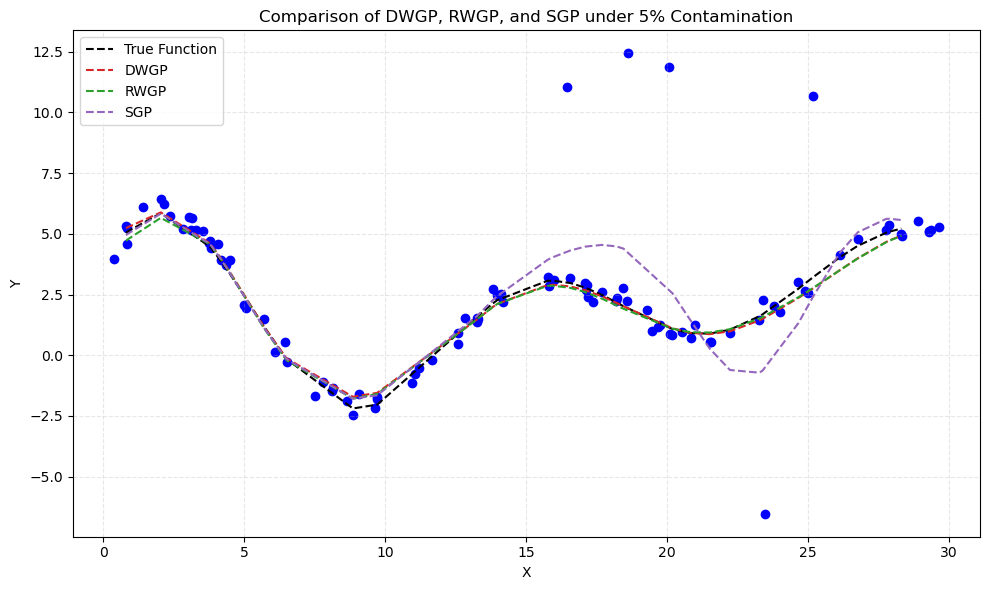

In [825]:
colors = {
    "true_function": "#000000",  # Black
    "observations": "#1f77b4",  # Blue
    "DWGP": "#d62728",  # Red
    "RWGP": "#2ca02c",  # Green
    "SGP": "#9467bd", # Purple
}


plt.figure(figsize=(10, 6))

# تابع واقعی
plt.plot(X_test, ground_truth_function(X_test), color=colors["true_function"], linestyle="dashed", label="True Function")
plt.scatter(X_test, y_test, color='blue')
plt.scatter(X_train, y_train, color='blue')
# پیش‌بینی مدل‌ها
plt.plot(X_test, mu_s_DWGP, color=colors["DWGP"], label="DWGP", linestyle="dashed")
plt.plot(X_test, mu_s_RWGP, color=colors["RWGP"], label="RWGP", linestyle="dashed")
plt.plot(X_test, mu_s_SGP, color=colors["SGP"], label="SGP", linestyle="dashed")


plt.xlabel("X")
plt.ylabel("Y")
plt.title("Comparison of DWGP, RWGP, and SGP under 5% Contamination")

plt.legend(loc="upper left", fontsize=10)
#plt.ylim([-5, 15])
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("plot5.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()

In [807]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_10, test_size = 0.4, random_state = 11)

# Ensure X_train is 2D
X_train = X_train.reshape(-1, 1)

y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1) 

sorted_indices = np.argsort(X_train.flatten())  # Get sorting indices
X_train = X_train[sorted_indices]  # Apply sorting to X_test
y_train = y_train[sorted_indices]  # Apply sorting to y_test

# Ensure that X_test and y_test are sorted together
sorted_indices = np.argsort(X_test.flatten())  # Get sorting indices
X_test = X_test[sorted_indices]  # Apply sorting to X_test
y_test = y_test[sorted_indices]  # Apply sorting to y_test


In [809]:
nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

depth = np.zeros(len(X_train))
for i in range(len(X_train)):
    depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
weight_depth_opt = fn.weight(1-depth, gamma, lamda)
mu_s_DWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)

In [811]:
w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)

In [813]:
mu_s_SGP, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)

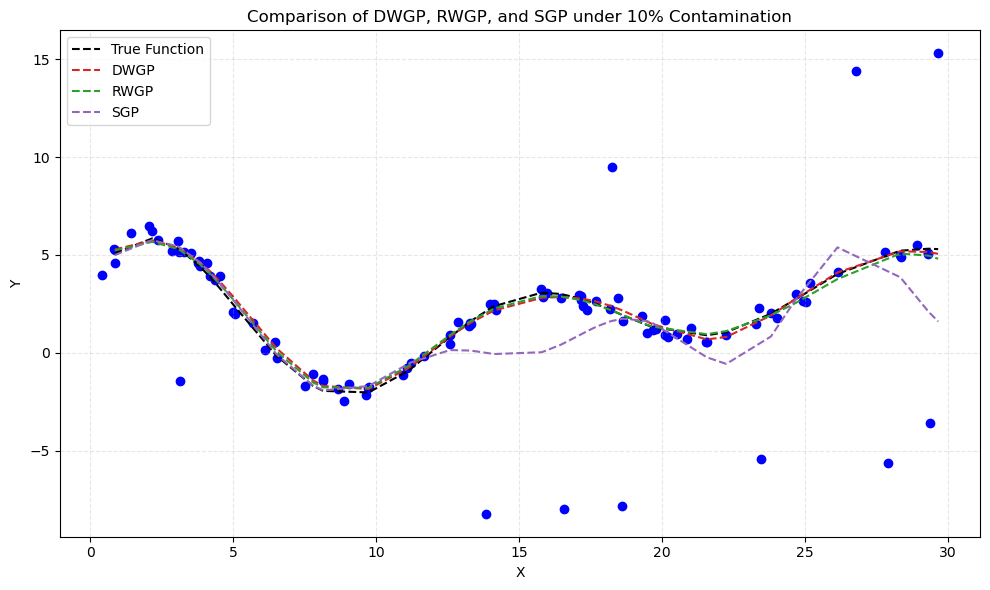

In [815]:
colors = {
    "true_function": "#000000",  # Black
    "observations": "#1f77b4",  # Blue
    "DWGP": "#d62728",  # Red
    "RWGP": "#2ca02c",  # Green
    "SGP": "#9467bd", # Purple
}


plt.figure(figsize=(10, 6))

# تابع واقعی
plt.plot(X_test, ground_truth_function(X_test), color=colors["true_function"], linestyle="dashed", label="True Function")
plt.scatter(X_test, y_test, color='blue')
plt.scatter(X_train, y_train, color='blue')
# پیش‌بینی مدل‌ها
plt.plot(X_test, mu_s_DWGP, color=colors["DWGP"], label="DWGP", linestyle="dashed")
plt.plot(X_test, mu_s_RWGP, color=colors["RWGP"], label="RWGP", linestyle="dashed")
plt.plot(X_test, mu_s_SGP, color=colors["SGP"], label="SGP", linestyle="dashed")


plt.xlabel("X")
plt.ylabel("Y")
plt.title("Comparison of DWGP, RWGP, and SGP under 10% Contamination")

plt.legend(loc="upper left", fontsize=10)
#plt.ylim([-5, 15])
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("plot10.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()

In [797]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_20, test_size = 0.4, random_state = 11)

# Ensure X_train is 2D
X_train = X_train.reshape(-1, 1)

y_train = y_train.reshape(-1, 1)

X_test = X_test.reshape(-1, 1) 

sorted_indices = np.argsort(X_train.flatten())  # Get sorting indices
X_train = X_train[sorted_indices]  # Apply sorting to X_test
y_train = y_train[sorted_indices]  # Apply sorting to y_test

# Ensure that X_test and y_test are sorted together
sorted_indices = np.argsort(X_test.flatten())  # Get sorting indices
X_test = X_test[sorted_indices]  # Apply sorting to X_test
y_test = y_test[sorted_indices]  # Apply sorting to y_test


In [799]:
nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
distances, indices = nbrs.kneighbors(X_train)

depth = np.zeros(len(X_train))
for i in range(len(X_train)):
    depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
weight_depth_opt = fn.weight(1-depth, gamma, lamda)
mu_s_DWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)

In [801]:
w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)

In [803]:
mu_s_SGP, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)

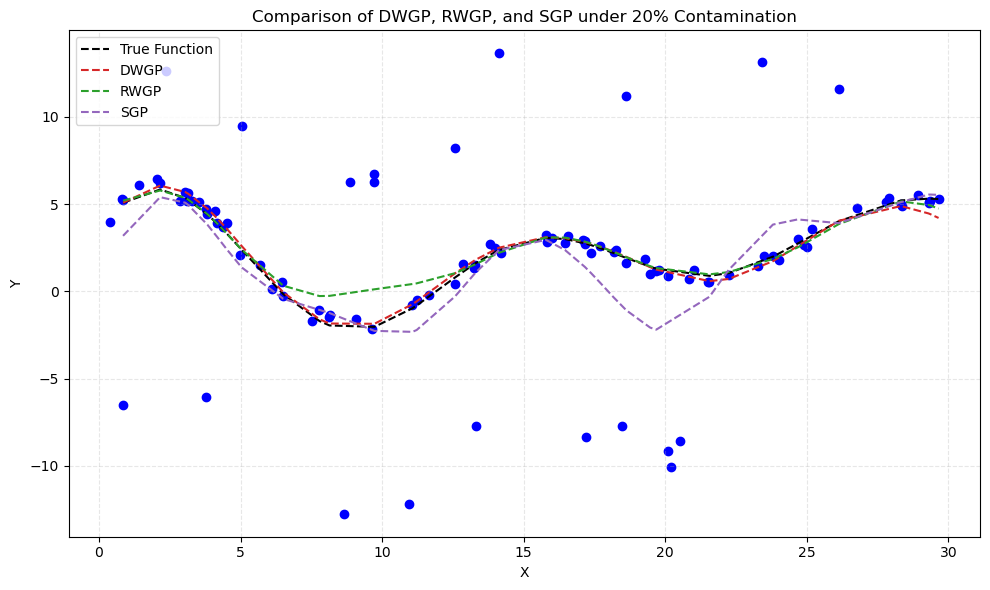

In [805]:
colors = {
    "true_function": "#000000",  # Black
    "observations": "#1f77b4",  # Blue
    "DWGP": "#d62728",  # Red
    "RWGP": "#2ca02c",  # Green
    "SGP": "#9467bd", # Purple
}


plt.figure(figsize=(10, 6))

# تابع واقعی
plt.plot(X_test, ground_truth_function(X_test), color=colors["true_function"], linestyle="dashed", label="True Function")
plt.scatter(X_test, y_test, color='blue')
plt.scatter(X_train, y_train, color='blue')
# پیش‌بینی مدل‌ها
plt.plot(X_test, mu_s_DWGP, color=colors["DWGP"], label="DWGP", linestyle="dashed")
plt.plot(X_test, mu_s_RWGP, color=colors["RWGP"], label="RWGP", linestyle="dashed")
plt.plot(X_test, mu_s_SGP, color=colors["SGP"], label="SGP", linestyle="dashed")


plt.xlabel("X")
plt.ylabel("Y")
plt.title("Comparison of DWGP, RWGP, and SGP under 20% Contamination")

plt.legend(loc="upper left", fontsize=10)
#plt.ylim([-5, 15])
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("plot20.pdf", format="pdf", bbox_inches="tight")
plt.tight_layout()